For descriptive purposes, this notebook contains several independent algorithms for predicting the mechanism of action of peptides based on sequence-based properties.
We explored multiple models until we discovered the most effective one for our dataset.

### Set directory

In [1]:
pwd='C:\\Users\\sakma\\Proyectos python'

### Modules

In [2]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install imblearn

In [1]:
import csv
import random
import urllib.request
import pandas                      as pd
import numpy                       as np
import seaborn                     as sns
import matplotlib.pyplot           as plt
from sklearn                       import preprocessing
from itertools                     import permutations 
from matplotlib                    import pyplot
from os                            import path
from imblearn.over_sampling        import RandomOverSampler,SMOTE,ADASYN
from sklearn.feature_selection     import VarianceThreshold
from sklearn.model_selection       import train_test_split,KFold
from sklearn                       import model_selection, metrics
from sklearn.model_selection       import StratifiedKFold
from sklearn.model_selection       import cross_val_score
from sklearn.metrics               import classification_report
from sklearn.metrics               import confusion_matrix
from sklearn.metrics               import accuracy_score
from sklearn.metrics               import recall_score
from sklearn.metrics               import f1_score
from sklearn.metrics               import precision_score
from sklearn.metrics               import (accuracy_score, cohen_kappa_score, roc_auc_score,
matthews_corrcoef, average_precision_score)
from sklearn.multioutput           import MultiOutputClassifier
from sklearn.multiclass            import OneVsRestClassifier
from sklearn.model_selection       import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm                   import LinearSVC
from sklearn.pipeline              import make_pipeline
from sklearn.linear_model          import LogisticRegression 
from sklearn.linear_model          import LogisticRegressionCV
from sklearn.neural_network        import MLPClassifier
from sklearn.neighbors             import NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors             import RadiusNeighborsClassifier
from sklearn.linear_model          import RidgeClassifier 
from sklearn.ensemble              import GradientBoostingClassifier
from sklearn.linear_model          import SGDClassifier
from sklearn.preprocessing         import StandardScaler
from sklearn.linear_model          import Perceptron
from sklearn.linear_model          import PassiveAggressiveClassifier
from sklearn.gaussian_process      import GaussianProcessClassifier
from sklearn.ensemble              import BaggingClassifier
from sklearn.ensemble              import RandomForestClassifier
from sklearn.naive_bayes           import BernoulliNB
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import BaggingClassifier
from sklearn.tree                  import ExtraTreeClassifier
from sklearn.ensemble              import ExtraTreesClassifier
from sklearn.naive_bayes           import GaussianNB
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.naive_bayes           import MultinomialNB

seed= 1408

### Data processing

In [2]:
#Loading dataset
Multilabel=pd.read_csv('PCPs_unique_MDPs_MPPs_PAPs.csv', index_col='ID')
Multilabel_model_lb= Multilabel.drop(Multilabel.columns[1:57],axis=1)
Multilabel_model_var = Multilabel.drop(Multilabel.columns[0],axis=1)
Multilabel_model_var.head(10)

,pI,hydrophobicity_Cid,hydrophobicity_Jones,hydrophobicity_Ponnuswamy,hydrophobicity_Welling,hydrophobicity_Zimmerman,charge,mw,Aliphatic,Acidic,...,z3,hydrophobicity_Janin,hydrophobicity_Wolfenden,Aromatic,Basic,%Aromatic,%Charged,Linear Moment,hmoment,hydrophobicity_Wilson
ID,,,,,,,,,,,,,,,,,,,,,
MDPs_1,10.348792,0.645500,2.031000,1.123500,-0.176000,2.033500,3.872855,2282.96054,9,0,...,-2.212000,0.025000,-1.437000,3,4,15.000,20.000,0.31,0.498470,3.015000
MDPs_2,8.821667,0.657857,2.065000,1.155000,-0.907857,2.030714,1.873445,1650.07254,3,0,...,-1.931429,0.142857,-1.482857,4,2,28.571,14.286,0.39,0.514542,3.650000
MDPs_3,10.512673,0.512857,1.869048,0.962381,-0.202381,1.927143,3.873146,2358.08934,9,0,...,-2.120476,0.009524,-1.711905,1,4,4.762,19.048,0.39,0.519428,3.028571
MDPs_4,12.283640,0.494444,1.883889,0.987778,-0.341667,1.893889,7.086853,2262.86274,7,0,...,-1.661111,-0.411111,-5.907222,2,8,11.111,44.444,0.27,1.040749,1.194444
MDPs_5,10.632522,-0.066400,1.114400,0.384800,0.263600,1.154800,4.872560,2637.15394,8,0,...,-0.588000,-0.212000,-3.297200,1,5,4.000,20.000,0.20,0.599911,1.332000
MDPs_6,10.348792,0.448333,1.712917,1.006250,-0.139167,1.749167,3.872855,2519.23164,11,0,...,-2.555000,0.075000,-0.683750,2,4,8.333,16.667,0.28,0.531900,2.966667
MDPs_7,7.880118,-0.213077,0.599231,0.384615,0.203846,0.663077,0.361621,1265.31324,2,0,...,-0.281538,0.115385,-3.045385,4,4,30.769,30.769,0.29,0.259329,0.907692
MDPs_8,8.792472,0.509583,1.812917,1.047083,-0.287917,1.883333,1.872594,2610.25424,11,0,...,-1.992083,0.133333,-0.946250,3,2,12.500,8.333,0.37,0.499506,3.129167
MDPs_9,12.695303,0.483103,1.841034,1.083793,-0.661724,1.876897,9.086846,3497.41354,12,0,...,-2.305517,-0.251724,-4.919310,2,10,6.897,34.483,0.24,0.954343,1.451724


In [3]:
#Normalize 
def normalize(Multilabel_model_var):
    result = Multilabel_model_var.copy()
    for feature_name in Multilabel_model_var.columns:
        max_value = Multilabel_model_var[feature_name].max()
        min_value = Multilabel_model_var[feature_name].min()
        result[feature_name] = (Multilabel_model_var[feature_name] - min_value) / (max_value - min_value)
    return result

Multilabel_model_norm = normalize(Multilabel_model_var)
Multilabel_model_norm.head(10)

,pI,hydrophobicity_Cid,hydrophobicity_Jones,hydrophobicity_Ponnuswamy,hydrophobicity_Welling,hydrophobicity_Zimmerman,charge,mw,Aliphatic,Acidic,...,z3,hydrophobicity_Janin,hydrophobicity_Wolfenden,Aromatic,Basic,%Aromatic,%Charged,Linear Moment,hmoment,hydrophobicity_Wilson
ID,,,,,,,,,,,,,,,,,,,,,
MDPs_1,0.681541,0.862297,0.672493,0.757972,0.336886,0.676705,0.432766,0.161771,0.191489,0.0,...,0.182545,0.813119,0.853482,0.166667,0.133333,0.224999,0.20000,0.492063,0.404588,0.769186
MDPs_2,0.536601,0.868545,0.686530,0.768293,0.161433,0.675528,0.389340,0.103310,0.063830,0.0,...,0.209226,0.865629,0.851364,0.222222,0.066667,0.428563,0.14286,0.619048,0.418495,0.843023
MDPs_3,0.697095,0.795233,0.605631,0.705185,0.330562,0.631762,0.432773,0.168710,0.191489,0.0,...,0.191249,0.806223,0.840788,0.055556,0.133333,0.071430,0.19048,0.619048,0.422722,0.770764
MDPs_4,0.865179,0.785924,0.611759,0.713506,0.297170,0.617710,0.502573,0.159914,0.148936,0.0,...,0.234933,0.618812,0.647062,0.111111,0.266667,0.166664,0.44444,0.428571,0.873831,0.557494
MDPs_5,0.708470,0.502362,0.294076,0.515952,0.442275,0.305394,0.454479,0.194488,0.170213,0.0,...,0.336983,0.707525,0.767584,0.055556,0.166667,0.060000,0.20000,0.317460,0.492366,0.573488
MDPs_6,0.681541,0.762610,0.541173,0.719558,0.345717,0.556555,0.432766,0.183595,0.234043,0.0,...,0.149927,0.835396,0.888264,0.111111,0.133333,0.124994,0.16667,0.444444,0.433515,0.763566
MDPs_7,0.447237,0.428202,0.081389,0.515891,0.427950,0.097608,0.356504,0.067769,0.042553,0.0,...,0.366126,0.853389,0.779212,0.222222,0.133333,0.461533,0.30769,0.460317,0.197654,0.524150
MDPs_8,0.533830,0.793578,0.582458,0.732936,0.310056,0.613249,0.389322,0.192003,0.234043,0.0,...,0.203458,0.861386,0.876143,0.166667,0.066667,0.187499,0.08333,0.587302,0.405484,0.782461
MDPs_9,0.904251,0.780190,0.594066,0.744963,0.220440,0.610530,0.546012,0.273951,0.255319,0.0,...,0.173652,0.689826,0.692681,0.111111,0.333333,0.103454,0.34483,0.380952,0.799062,0.587410


In [4]:
#Concat label and variables
Multilabel_model_cct=pd.concat([Multilabel_model_lb,Multilabel_model_norm], axis=1)
Multilabel_model_cct.head(10)

,Label,pI,hydrophobicity_Cid,hydrophobicity_Jones,hydrophobicity_Ponnuswamy,hydrophobicity_Welling,hydrophobicity_Zimmerman,charge,mw,Aliphatic,...,z3,hydrophobicity_Janin,hydrophobicity_Wolfenden,Aromatic,Basic,%Aromatic,%Charged,Linear Moment,hmoment,hydrophobicity_Wilson
ID,,,,,,,,,,,,,,,,,,,,,
MDPs_1,MDPs,0.681541,0.862297,0.672493,0.757972,0.336886,0.676705,0.432766,0.161771,0.191489,...,0.182545,0.813119,0.853482,0.166667,0.133333,0.224999,0.20000,0.492063,0.404588,0.769186
MDPs_2,MDPs,0.536601,0.868545,0.686530,0.768293,0.161433,0.675528,0.389340,0.103310,0.063830,...,0.209226,0.865629,0.851364,0.222222,0.066667,0.428563,0.14286,0.619048,0.418495,0.843023
MDPs_3,MDPs,0.697095,0.795233,0.605631,0.705185,0.330562,0.631762,0.432773,0.168710,0.191489,...,0.191249,0.806223,0.840788,0.055556,0.133333,0.071430,0.19048,0.619048,0.422722,0.770764
MDPs_4,MDPs,0.865179,0.785924,0.611759,0.713506,0.297170,0.617710,0.502573,0.159914,0.148936,...,0.234933,0.618812,0.647062,0.111111,0.266667,0.166664,0.44444,0.428571,0.873831,0.557494
MDPs_5,MDPs,0.708470,0.502362,0.294076,0.515952,0.442275,0.305394,0.454479,0.194488,0.170213,...,0.336983,0.707525,0.767584,0.055556,0.166667,0.060000,0.20000,0.317460,0.492366,0.573488
MDPs_6,MDPs,0.681541,0.762610,0.541173,0.719558,0.345717,0.556555,0.432766,0.183595,0.234043,...,0.149927,0.835396,0.888264,0.111111,0.133333,0.124994,0.16667,0.444444,0.433515,0.763566
MDPs_7,MDPs,0.447237,0.428202,0.081389,0.515891,0.427950,0.097608,0.356504,0.067769,0.042553,...,0.366126,0.853389,0.779212,0.222222,0.133333,0.461533,0.30769,0.460317,0.197654,0.524150
MDPs_8,MDPs,0.533830,0.793578,0.582458,0.732936,0.310056,0.613249,0.389322,0.192003,0.234043,...,0.203458,0.861386,0.876143,0.166667,0.066667,0.187499,0.08333,0.587302,0.405484,0.782461
MDPs_9,MDPs,0.904251,0.780190,0.594066,0.744963,0.220440,0.610530,0.546012,0.273951,0.255319,...,0.173652,0.689826,0.692681,0.111111,0.333333,0.103454,0.34483,0.380952,0.799062,0.587410


In [5]:
# Label character to numeric
Lab_num_mlabel=preprocessing.LabelEncoder()
Lab_num_mlabel.fit(Multilabel_model_cct.Label)
new_lab=Lab_num_mlabel.transform(Multilabel_model_cct.Label)
Multilabel_model_cct.Label=new_lab
Lab_num_mlabel.classes_

array(['MDPs', 'MPPs', 'PAPs'], dtype=object)

In [6]:
#Loading multilabel models
model_RF  = RandomForestClassifier(random_state=seed,verbose=False)
model_ETC = ExtraTreeClassifier(random_state=seed)
model_KNN = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
model_NN  = MLPClassifier(random_state=seed,max_iter=2000)
model_RNC = RadiusNeighborsClassifier(radius=3.0)
model_DTC = DecisionTreeClassifier(random_state=seed)
model_RC  = RidgeClassifier()
model_BNB = BernoulliNB()
model_GAUS= GaussianNB()
model_LDA = LinearDiscriminantAnalysis()
model_NC  = NearestCentroid()
model_GBC = GradientBoostingClassifier(random_state=seed,verbose=False)
model_SGDC= SGDClassifier(loss='log_loss', random_state=seed)
model_P   = NearestCentroid()
model_PAC = PassiveAggressiveClassifier(max_iter=2000, random_state=seed,tol=1e-5)
model_MNB = MultinomialNB()
model_LR  = LogisticRegression(random_state=seed, verbose=False)
model_QDA = QuadraticDiscriminantAnalysis()

In [7]:
#Data splitting  
Ds_splt_ml=Multilabel_model_cct
metrics = []
X_train_MLb,X_validation_MLb,Y_train_MLb,Y_validation_MLb= train_test_split(Ds_splt_ml[Ds_splt_ml.columns[1:len(Ds_splt_ml.columns)]],
                                                                        Ds_splt_ml[Ds_splt_ml.columns[0]],test_size=0.20,random_state=1408)

In [8]:
# ROSE for Multilabel Imbalanced data
rose=SMOTE(random_state=seed)
X_train_rose,Y_train_rose=rose.fit_resample(X_train_MLb,Y_train_MLb)

In [9]:
#Training models
model_rf  = model_RF.fit(X_train_rose,Y_train_rose)
model_etc = model_ETC.fit(X_train_rose,Y_train_rose)
model_knn = model_KNN.fit(X_train_rose,Y_train_rose)
model_nn  = model_NN.fit(X_train_rose,Y_train_rose)
model_rnc = model_RNC.fit(X_train_rose,Y_train_rose)
model_dtc = model_DTC.fit(X_train_rose,Y_train_rose)
model_rc  = model_RC.fit(X_train_rose,Y_train_rose)
model_bnb = model_BNB.fit(X_train_rose,Y_train_rose)
model_gaus= model_GAUS.fit(X_train_rose,Y_train_rose)
model_lda = model_LDA.fit(X_train_rose,Y_train_rose)
model_nc  = model_NC.fit(X_train_rose,Y_train_rose)
model_gbc = model_GBC.fit(X_train_rose,Y_train_rose)
model_sgdc= model_SGDC.fit(X_train_rose,Y_train_rose)
model_p   = model_P.fit(X_train_rose,Y_train_rose)
model_pac = model_PAC.fit(X_train_rose,Y_train_rose)
model_mnb = model_MNB.fit(X_train_rose,Y_train_rose)

In [10]:
#List
train_shape=list(X_train_rose.shape)
test_shape=list(X_validation_MLb.shape)

### Ternary models

### Random Forest

In [11]:
model_trained= model_rf
X = X_train_rose
Y = Y_train_rose
cv_preds = model_selection.cross_val_predict(model_trained, X, Y, cv=10)

# Save metrics
accuracy  = cross_val_score(model_RF, X_train_rose, Y_train_rose, cv=10, scoring='accuracy').mean()*100
precision = cross_val_score(model_RF, X_train_rose, Y_train_rose, cv=10, scoring='precision_macro').mean()*100
recall  = cross_val_score(model_RF, X_train_rose, Y_train_rose, cv=10, scoring='recall_macro').mean()
F1      = cross_val_score(model_RF, X_train_rose, Y_train_rose, cv=10, scoring='f1_macro').mean()
MC      = matthews_corrcoef(Y_train_rose,cv_preds)
CK      = cohen_kappa_score(Y_train_rose,cv_preds)

metrics_cv_rf= {'validation_type/Model':'cv/model','Rows_training':train_shape[0],'columns_training':train_shape[1],
               'Rows_test':test_shape[0],'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_score':F1,
               'Matthews':MC,'Cohen_Kappa':CK}
metrics.append(metrics_cv_rf)

index = ['Multilabel']
Ds_metrics_models_model_set = pd.DataFrame(metrics_cv_rf, index=index)
Ds_metrics_models_model_set

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,cv/model,999,56,212,83.990909,84.431921,0.840048,0.838931,0.760633,0.75976


In [12]:
# Splitting Validation 
model_ml_trained_RF    = model_rf
X_sp= X_validation_MLb
Y_sp = Y_validation_MLb
pred_RF_sp_val= model_ml_trained_RF.predict(X_sp)

#Accuracy
acc_int = accuracy_score(Y_sp,pred_RF_sp_val)*100
# Precision
precision_int = precision_score(Y_sp,pred_RF_sp_val, average='macro')*100
# Recall
recall_int = recall_score(Y_sp,pred_RF_sp_val, average='macro')
# F1 score
f1_int = f1_score(Y_sp,pred_RF_sp_val, average='macro')
# Matthews
mc_int = matthews_corrcoef(Y_sp,pred_RF_sp_val)
# Cohen_Kappa
ck_int = cohen_kappa_score(Y_sp,pred_RF_sp_val)

#Save metrics of splitting validation

metrics_ml_RF_val_int={'validation_type/Model':'int/RF','Rows_training':train_shape[0],'columns_training':test_shape[1],
                    'Rows_test':test_shape[0],'Accuracy':acc_int,'Precision':precision_int,'Recall':recall_int,'F1_score':f1_int,
               'Matthews':mc_int,'Cohen_Kappa':ck_int}


metrics.append(metrics_ml_RF_val_int)
metrics_ml_RF_val_int
index = ['Multilabel']
Ds_metrics_RF_int =pd.DataFrame(metrics_ml_RF_val_int,index=index)
Ds_metrics_RF_int

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,int/RF,999,56,212,83.962264,84.502433,0.840147,0.840429,0.75918,0.757568


In [13]:
#Features importance
names=X_train_rose.columns
importance_RF= model_rf.feature_importances_
importance_RF_df={'Features':names,'Importance_value':importance_RF}
importance_RF=pd.DataFrame(importance_RF_df)
importance_RF.sort_values(by=['Importance_value'],inplace=True,ascending=False)
rf_imp=importance_RF.head(56)
rf_imp

,Features,Importance_value
7,mw,0.069530
29,Charge Density,0.047151
9,Acidic,0.042997
37,cougar,0.042013
16,Electrophilicity,0.041841
8,Aliphatic,0.029662
18,H_bonding,0.028858
25,Propensity to in vitro Aggregation,0.024661
47,hydrophobicity_Janin,0.024552
32,Hydroph Ratio,0.023422


In [14]:
#Reorder features
custom_order = ['mw','Charge Density','Acidic', 'cougar', 'Electrophilicity', 'H_bonding','Aliphatic','hydrophobicity_Janin',
                'Angle Subtended by the Hydrophobic Residues','Local_flexibility','pI','Aromatic','%Acidic',
                'Propensity to in vitro Aggregation','hydrophobicity_Wolfenden','Hydroph Ratio','Instability Index','flexibility',
                '%Tiny','charge','MSS','Compositional_characteristic_index','Ez', 'argos','z3','hmoment','Hardness',
                'Hydrophobicity_index','Propensity to PPII coil', 'hydrophobicity_Welling', 'Amphiphilicity Index',
                'Electronic properties1','ABHPRK','Bulky properties','bulkiness','hydrophobicity_Ponnuswamy','levitt_alpha',
                '%Aliphatic','hydrophobicity_Zimmerman','AASI','PPCALI','refractivity','Aromaticity', 'hydrophobicity_Cid',
                'Electronic properties2','t_scale', 'Penetration Depth', 'Basic', '%Aromatic', 'pepcats','%Charged',
                'hydrophobicity_Jones', 'hydrophobicity_Wilson','%Polar', '%Small','Linear Moment']

# Reorder dataframe
importance_RF = importance_RF.set_index('Features').loc[custom_order].reset_index()
#Save file
importance_RF.to_csv ('C:\\Users\\sakma\\Proyectos Python\\Artículo ordenado\\Ternary_model.csv', 
               index = True, header = True)

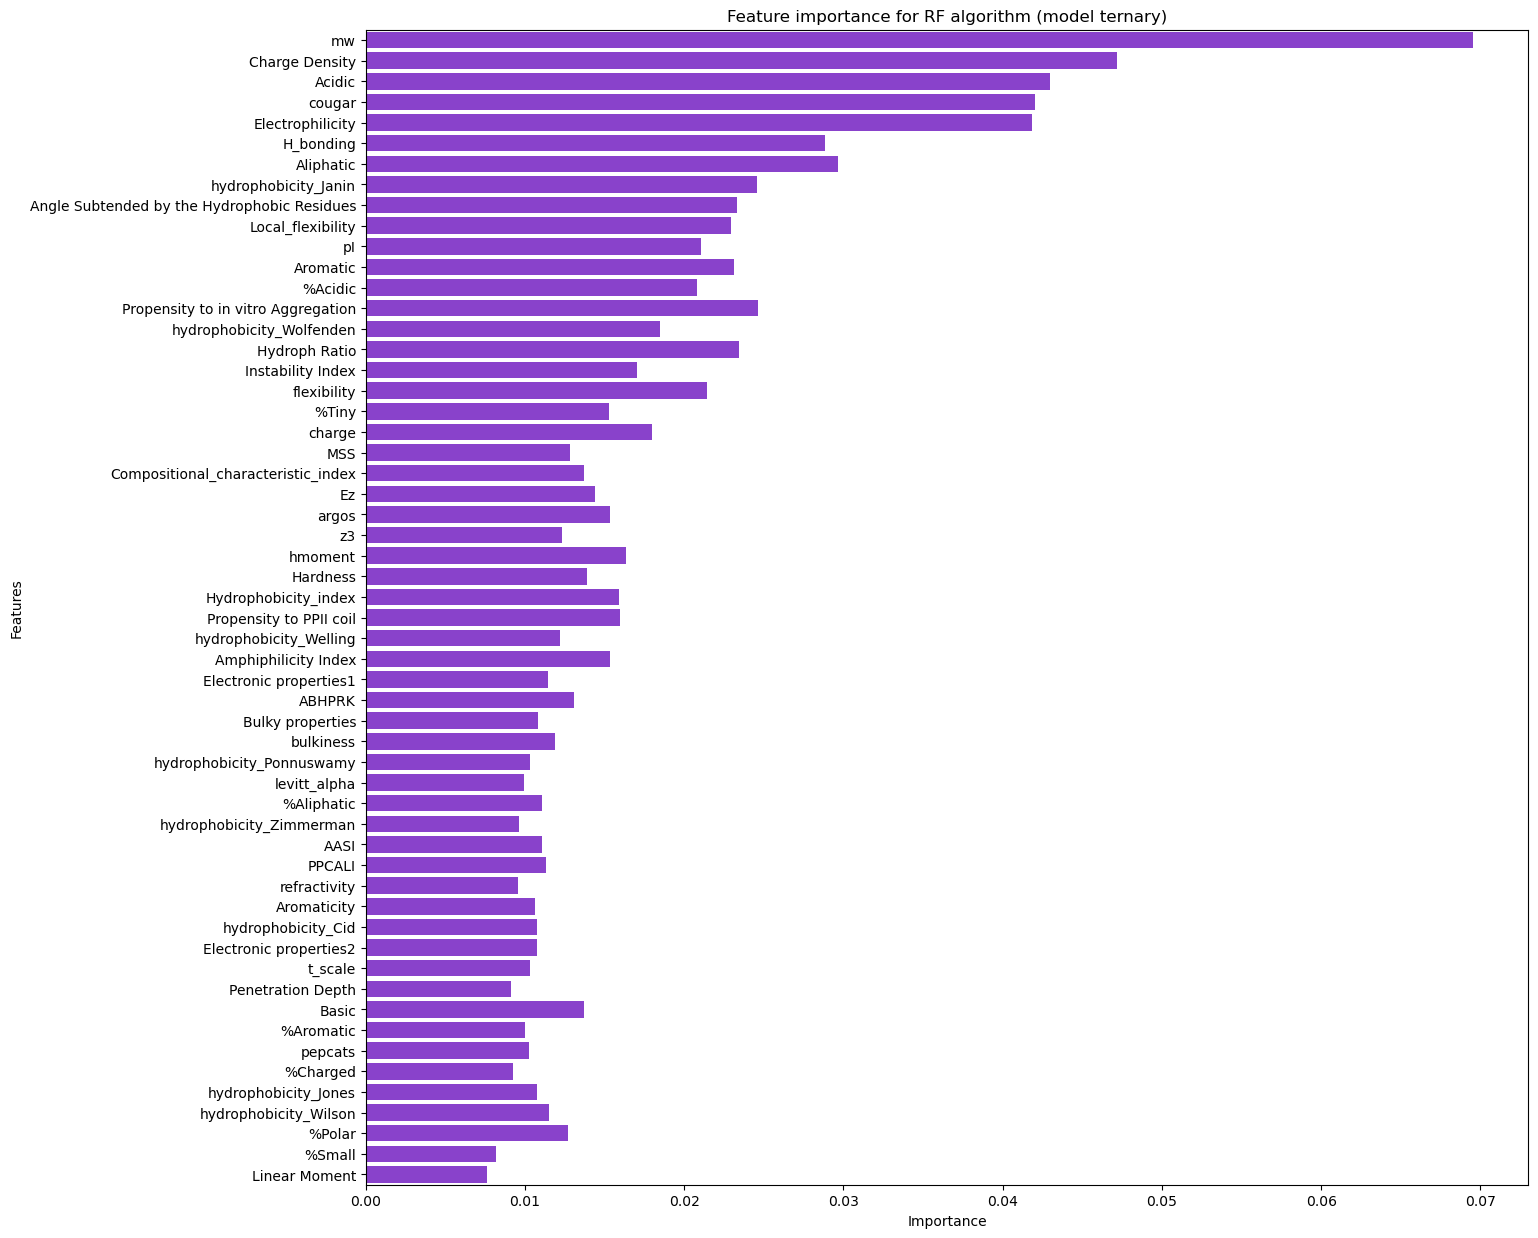

In [15]:
#Plot 
pyplot.figure(figsize=(15,15))
plot=sns.barplot(data=importance_RF,y='Features',x='Importance_value',color='#8A2BE2')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature importance for RF algorithm (model ternary)")
plt.savefig("FI_model 1.0.pdf")
plt.show(plot)

### External Validation

In [16]:
Mech_validation=pd.read_csv('ExVal_T1.csv', index_col='ID')
#Separate label and variables
Mech_validation_lb= Mech_validation.drop(Mech_validation.columns[1:57],axis=1)
Mech_validation_lb.head(10)
#Drop Label
Mech_validation_wl =Mech_validation.drop(['Label'], axis=1)
Mech_validation_wl.head(10)

,pI,hydrophobicity_Cid,hydrophobicity_Jones,hydrophobicity_Ponnuswamy,hydrophobicity_Welling,hydrophobicity_Zimmerman,charge,mw,Aliphatic,Acidic,...,z3,hydrophobicity_Janin,hydrophobicity_Wolfenden,Aromatic,Basic,%Aromatic,%Charged,Linear Moment,hmoment,hydrophobicity_Wilson
ID,,,,,,,,,,,,,,,,,,,,,
ExtVal_1,10.41,-0.048788,0.462727,0.365152,0.660606,1.065152,3.001539,3181.72634,17,3,...,-1.492727,1.176667,-1.822424,1,6,3.030,27.273,0.25,0.677535,0.660606
ExtVal_2,6.26,0.383077,0.946154,-0.710000,1.769231,1.777692,-0.000384,1446.75004,6,2,...,-2.209231,1.791538,-2.369231,1,2,7.692,30.769,0.35,0.730000,1.769231
ExtVal_3,9.93,0.297500,0.952500,-0.145625,2.712500,1.491250,0.997841,1615.97674,8,1,...,-3.016250,1.457500,-0.733750,1,2,6.250,18.750,0.42,0.558115,2.712500
ExtVal_8,10.73,0.343000,1.004500,-0.316000,3.005000,1.610500,1.997394,1918.43704,11,0,...,-3.761500,1.527500,0.587500,0,2,0.000,10.000,0.51,0.488597,3.005000
ExtVal_11,11.80,0.017838,0.276486,0.160270,0.889189,1.528378,11.996684,4453.43954,9,2,...,-0.757838,1.503243,-5.965135,3,14,8.108,43.243,0.21,0.671745,0.889189
ExtVal_12,10.41,0.074595,0.645946,0.045405,1.689189,1.211081,4.872711,3820.61044,14,1,...,-1.872432,1.242973,-2.148378,2,6,5.405,18.919,0.13,0.715239,1.689189
ExtVal_13,11.16,0.386923,0.700769,0.909231,1.769231,1.598462,3.996804,1511.95774,7,0,...,-2.525385,1.745385,-2.603846,1,4,7.692,30.769,0.25,0.661976,1.769231
ExtVal_14,11.94,0.494444,0.987778,-0.341667,1.194444,1.893889,7.086853,2262.86274,7,0,...,-1.661111,1.883889,-5.907222,2,8,11.111,44.444,0.27,1.040749,1.194444
ExtVal_17,11.27,0.514667,0.834667,0.408667,2.280000,1.746667,4.996509,1771.30904,7,0,...,-2.736000,1.947333,-2.462667,2,5,13.333,33.333,0.28,0.687035,2.280000


In [17]:
# Normalize test dataset based on training dataset
def normalize(Mech_validation_wl,Multilabel_model_var):
    result = Mech_validation_wl.copy()
    for feature_name in Multilabel_model_var.columns:
        max_value = Multilabel_model_var[feature_name].max()
        min_value = Multilabel_model_var[feature_name].min()
        result[feature_name] = (Mech_validation_wl[feature_name] - min_value) / (max_value - min_value)
    return result

Mech_val_norm= normalize(Mech_validation_wl,Multilabel_model_var)

#Prediction
Mech_val_predict=pd.DataFrame(model_ml_trained_RF.predict(Mech_val_norm))
Mech_val_predict
#Save file
Mech_val_predict.to_csv ('C:\\Users\\sakma\\Proyectos Python\\Artículo ordenado\\prob_Model5_valEx5_5.csv', 
               index = True, header = True)

In [18]:
#Probability of each label
Mech_val_prob=pd.DataFrame(model_rf.predict_proba(Mech_val_norm))
Mech_val_prob

,0,1,2
0,0.540000,0.370000,0.09
1,0.570000,0.250000,0.18
2,0.830000,0.120000,0.05
3,0.570000,0.360000,0.07
4,0.703333,0.196667,0.10
...,...,...,...
86,0.512000,0.328000,0.16
87,0.310000,0.650000,0.04
88,0.590000,0.140000,0.27
89,0.190000,0.220000,0.59


In [19]:
#Save model set results into dataframe
Mech_val_class = pd.DataFrame(model_trained.predict(Mech_val_norm))
Mech_val_df =Mech_val_class.merge(Mech_val_prob, how='outer', left_index=True, right_index=True)
Mech_val_df.index = Mech_val_norm.index
Mech_val_df.columns = ['Model1_class_pr', 'Model1_prob_MDPs', 'Model1_prob_MPPs','Model1_prob_PAPs']
Mech_val_df

,Model1_class_pr,Model1_prob_MDPs,Model1_prob_MPPs,Model1_prob_PAPs
ID,,,,
ExtVal_1,0,0.540000,0.370000,0.09
ExtVal_2,0,0.570000,0.250000,0.18
ExtVal_3,0,0.830000,0.120000,0.05
ExtVal_8,0,0.570000,0.360000,0.07
ExtVal_11,0,0.703333,0.196667,0.10
...,...,...,...,...
ExtVal_24,0,0.512000,0.328000,0.16
ExtVal_32,1,0.310000,0.650000,0.04
ExtVal_62,0,0.590000,0.140000,0.27


In [20]:
#Save file
Mech_val_df.to_csv ('C:\\Users\\sakma\\Proyectos Python\\Artículo ordenado\\prob_Mod4_valEx5_ternary.csv', 
               index = True, header = True)

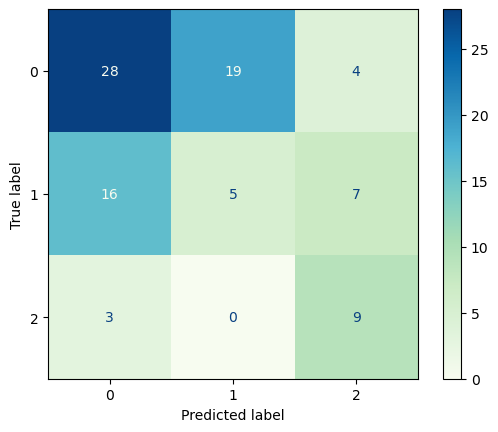

In [21]:
#Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(Mech_validation_lb, Mech_val_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model_trained.classes_)

#Plotting
cmap = plt.get_cmap('GnBu')
disp.plot(cmap=cmap, values_format='.0f')
#Save plot
plt.savefig("Mtx_confusion_Modelo_2.1.pdf")
plt.show()

### Extra Tree Classifier

In [22]:
model_trained= model_etc
X = X_train_rose
Y = Y_train_rose
cv_preds = model_selection.cross_val_predict(model_trained, X, Y, cv=10)

# Save metrics
accuracy  = cross_val_score(model_ETC, X_train_rose, Y_train_rose, cv=10, scoring='accuracy').mean()*100
precision = cross_val_score(model_ETC, X_train_rose, Y_train_rose, cv=10, scoring='precision_macro').mean()*100
recall  = cross_val_score(model_ETC, X_train_rose, Y_train_rose, cv=10, scoring='recall_macro').mean()
F1      = cross_val_score(model_ETC, X_train_rose, Y_train_rose, cv=10, scoring='f1_macro').mean()
MC      = matthews_corrcoef(Y_train_rose,cv_preds)
CK      = cohen_kappa_score(Y_train_rose,cv_preds)

metrics_cv_ETC= {'validation_type/Model':'cv/model','Rows_training':train_shape[0],'columns_training':train_shape[1],
               'Rows_test':test_shape[0],'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_score':F1,
               'Matthews':MC,'Cohen_Kappa':CK}
metrics.append(metrics_cv_ETC)

index = ['Multilabel']
Ds_metrics_models_model_set = pd.DataFrame(metrics_cv_ETC, index=index)
Ds_metrics_models_model_set


,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,cv/model,999,56,212,71.384848,71.631268,0.714201,0.712432,0.570779,0.570571


In [26]:
# Splitting Validation 
model_ml_trained_ETC= model_etc
X_sp= X_validation_MLb
Y_sp = Y_validation_MLb
pred_ETC_sp_val= model_ml_trained_ETC.predict(X_sp)

#Accurancy
acc_int = accuracy_score(Y_sp,pred_ETC_sp_val)*100
# Precision
precision_int = precision_score(Y_sp,pred_ETC_sp_val, average='macro')*100
# Recall
recall_int = recall_score(Y_sp,pred_ETC_sp_val, average='macro')
# F1 score
f1_int = f1_score(Y_sp,pred_ETC_sp_val, average='macro')
# Matthews
mc_int = matthews_corrcoef(Y_sp,pred_ETC_sp_val)
# Cohen_Kappa
ck_int = cohen_kappa_score(Y_sp,pred_ETC_sp_val)

#Save metrics of splitting validation

metrics_ml_ETC_val_int={'validation_type/Model':'int/ETC','Rows_training':train_shape[0],'columns_training':test_shape[1],
                    'Rows_test':test_shape[0],'Accuracy':acc_int,'Precision':precision_int,'Recall':recall_int,'F1_score':f1_int,
               'Matthews':mc_int,'Cohen_Kappa':ck_int}


metrics.append(metrics_ml_ETC_val_int)
metrics_ml_ETC_val_int
index = ['Multilabel']
Ds_metrics_ETC_int =pd.DataFrame(metrics_ml_ETC_val_int,index=index)
Ds_metrics_ETC_int

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,int/ETC,999,56,212,70.754717,71.504099,0.697351,0.700196,0.559325,0.55432


### KNN

In [27]:
model_trained= model_knn
X = X_train_rose
Y = Y_train_rose
cv_preds = model_selection.cross_val_predict(model_trained, X, Y, cv=10)

# Save metrics
accuracy  = cross_val_score(model_KNN, X_train_rose, Y_train_rose, cv=10, scoring='accuracy').mean()*100
precision = cross_val_score(model_KNN, X_train_rose, Y_train_rose, cv=10, scoring='precision_macro').mean()*100
recall  = cross_val_score(model_KNN, X_train_rose, Y_train_rose, cv=10, scoring='recall_macro').mean()
F1      = cross_val_score(model_KNN, X_train_rose, Y_train_rose, cv=10, scoring='f1_macro').mean()
MC      = matthews_corrcoef(Y_train_rose,cv_preds)
CK      = cohen_kappa_score(Y_train_rose,cv_preds)

metrics_cv_KNN= {'validation_type/Model':'cv/model','Rows_training':train_shape[0],'columns_training':train_shape[1],
               'Rows_test':test_shape[0],'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_score':F1,
               'Matthews':MC,'Cohen_Kappa':CK}
metrics.append(metrics_cv_KNN)

index = ['Multilabel']
Ds_metrics_models_model_set = pd.DataFrame(metrics_cv_KNN, index=index)
Ds_metrics_models_model_set

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,cv/model,999,56,212,80.688889,80.983592,0.806803,0.805127,0.710887,0.71021


In [28]:
# Splitting Validation 
model_ml_trained_KNN= model_knn
X_sp= X_validation_MLb
Y_sp = Y_validation_MLb
pred_KNN_sp_val= model_ml_trained_KNN.predict(X_sp)


#Accurancy
acc_int = accuracy_score(Y_sp,pred_KNN_sp_val)*100
# Precision
precision_int = precision_score(Y_sp,pred_KNN_sp_val, average='macro')*100
# Recall
recall_int = recall_score(Y_sp,pred_KNN_sp_val, average='macro')
# F1 score
f1_int = f1_score(Y_sp,pred_KNN_sp_val, average='macro')
# Matthews
mc_int = matthews_corrcoef(Y_sp,pred_KNN_sp_val)
# Cohen_Kappa
ck_int = cohen_kappa_score(Y_sp,pred_KNN_sp_val)

#Save metrics of splitting validation

metrics_ml_KNN_val_int={'validation_type/Model':'int/KNN','Rows_training':train_shape[0],'columns_training':test_shape[1],
                    'Rows_test':test_shape[0],'Accuracy':acc_int,'Precision':precision_int,'Recall':recall_int,'F1_score':f1_int,
               'Matthews':mc_int,'Cohen_Kappa':ck_int}


metrics.append(metrics_ml_KNN_val_int)
metrics_ml_KNN_val_int
index = ['Multilabel']
Ds_metrics_KNN_int =pd.DataFrame(metrics_ml_KNN_val_int,index=index)
Ds_metrics_KNN_int

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,int/KNN,999,56,212,78.301887,78.753129,0.781708,0.782774,0.672995,0.671606


### Radius Neighbors Classifier

In [29]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, precision_recall_fscore_support
from sklearn.metrics import make_scorer

model_trained= model_rnc
X = X_train_rose
Y = Y_train_rose
cv_preds = model_selection.cross_val_predict(model_trained, X, Y, cv=10)

# Save metrics
accuracy  = cross_val_score(model_RNC, X_train_rose, Y_train_rose, cv=10, scoring='accuracy').mean()*100
#precision = cross_val_score(model_RNC, X_train_rose, Y_train_rose, cv=10, scoring='precision_macro').mean()*100
recall  = cross_val_score(model_RNC, X_train_rose, Y_train_rose, cv=10, scoring='recall_macro').mean()
F1      = cross_val_score(model_RNC, X_train_rose, Y_train_rose, cv=10, scoring='f1_macro').mean()
MC      = matthews_corrcoef(Y_train_rose,cv_preds)
CK      = cohen_kappa_score(Y_train_rose,cv_preds)

# Métricas multiclase
precision_scorer = make_scorer(precision_score, average='macro', zero_division=1)
precision = cross_val_score(model_RNC, X_train_rose, Y_train_rose, cv=10, scoring=precision_scorer).mean() * 100


metrics_cv_RNC= {'validation_type/Model':'cv/model','Rows_training':train_shape[0],'columns_training':train_shape[1],
               'Rows_test':test_shape[0],'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_score':F1,
               'Matthews':MC,'Cohen_Kappa':CK}
metrics.append(metrics_cv_RNC)

index = ['Multilabel']
Ds_metrics_models_model_set = pd.DataFrame(metrics_cv_RNC, index=index)
Ds_metrics_models_model_set


,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,cv/model,999,56,212,33.828283,48.17859,0.340998,0.296231,0.007551,0.007508


In [30]:
# Splitting Validation 
model_ml_trained_RNC= model_rnc
X_sp= X_validation_MLb
Y_sp = Y_validation_MLb
pred_RNC_sp_val= model_ml_trained_RNC.predict(X_sp)

#Accurancy
acc_int = accuracy_score(Y_sp,pred_RNC_sp_val)*100
# Precision
precision_int = precision_score(Y_sp,pred_RNC_sp_val, average='macro',zero_division=1)*100
# Recall
recall_int = recall_score(Y_sp,pred_RNC_sp_val, average='macro')
# F1 score
f1_int = f1_score(Y_sp,pred_RNC_sp_val, average='macro')
# Matthews
mc_int = matthews_corrcoef(Y_sp,pred_RNC_sp_val)
# Cohen_Kappa
ck_int = cohen_kappa_score(Y_sp,pred_RNC_sp_val)

#Save metrics of splitting validation

metrics_ml_RNC_val_int={'validation_type/Model':'int/RNC','Rows_training':train_shape[0],'columns_training':test_shape[1],
                    'Rows_test':test_shape[0],'Accuracy':acc_int,'Precision':precision_int,'Recall':recall_int,'F1_score':f1_int,
               'Matthews':mc_int,'Cohen_Kappa':ck_int}


metrics.append(metrics_ml_RNC_val_int)
metrics_ml_RNC_val_int
index = ['Multilabel']
Ds_metrics_RNC_int =pd.DataFrame(metrics_ml_RNC_val_int,index=index)
Ds_metrics_RNC_int

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,int/RNC,999,56,212,33.490566,35.316014,0.346291,0.34714,0.002423,0.002403


### Decision Tree Classifier

In [31]:
model_trained= model_dtc
X = X_train_rose
Y = Y_train_rose
cv_preds = model_selection.cross_val_predict(model_trained, X, Y, cv=10)

# Save metrics
accuracy  = cross_val_score(model_DTC, X_train_rose, Y_train_rose, cv=10, scoring='accuracy').mean()*100
precision = cross_val_score(model_DTC, X_train_rose, Y_train_rose, cv=10, scoring='precision_macro').mean()*100
recall  = cross_val_score(model_DTC, X_train_rose, Y_train_rose, cv=10, scoring='recall_macro').mean()
F1      = cross_val_score(model_DTC, X_train_rose, Y_train_rose, cv=10, scoring='f1_macro').mean()
MC      = matthews_corrcoef(Y_train_rose,cv_preds)
CK      = cohen_kappa_score(Y_train_rose,cv_preds)

metrics_cv_DTC= {'validation_type/Model':'cv/model','Rows_training':train_shape[0],'columns_training':train_shape[1],
               'Rows_test':test_shape[0],'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_score':F1,
               'Matthews':MC,'Cohen_Kappa':CK}
metrics.append(metrics_cv_DTC)

index = ['Multilabel']
Ds_metrics_models_model_set = pd.DataFrame(metrics_cv_DTC, index=index)
Ds_metrics_models_model_set

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,cv/model,999,56,212,73.778788,74.19084,0.737938,0.735715,0.606779,0.606607


In [32]:
# Splitting Validation 
model_ml_trained_DTC = model_dtc
X_sp= X_validation_MLb
Y_sp = Y_validation_MLb
pred_DTC_sp_val= model_ml_trained_DTC.predict(X_sp)

#Accurancy
acc_int = accuracy_score(Y_sp,pred_DTC_sp_val)*100
# Precision
precision_int = precision_score(Y_sp,pred_DTC_sp_val, average='macro')*100
# Recall
recall_int = recall_score(Y_sp,pred_DTC_sp_val, average='macro')
# F1 score
f1_int = f1_score(Y_sp,pred_DTC_sp_val, average='macro')
# Matthews
mc_int = matthews_corrcoef(Y_sp,pred_DTC_sp_val)
# Cohen_Kappa
ck_int = cohen_kappa_score(Y_sp,pred_DTC_sp_val)

#Save metrics of splitting validation

metrics_ml_DTC_val_int={'validation_type/Model':'int/DTC','Rows_training':train_shape[0],'columns_training':test_shape[1],
                    'Rows_test':test_shape[0],'Accuracy':acc_int,'Precision':precision_int,'Recall':recall_int,'F1_score':f1_int,
               'Matthews':mc_int,'Cohen_Kappa':ck_int}


metrics.append(metrics_ml_DTC_val_int)
metrics_ml_DTC_val_int
index = ['Multilabel']
Ds_metrics_DTC_int =pd.DataFrame(metrics_ml_DTC_val_int,index=index)
Ds_metrics_DTC_int

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,int/DTC,999,56,212,73.584906,73.511614,0.734671,0.734573,0.60105,0.600807


###  Naive Bayes

In [33]:
model_trained= model_gaus
X = X_train_rose
Y = Y_train_rose
cv_preds = model_selection.cross_val_predict(model_trained, X, Y, cv=10)

# Save metrics
accuracy  = cross_val_score(model_GAUS, X_train_rose, Y_train_rose, cv=10, scoring='accuracy').mean()*100
precision = cross_val_score(model_GAUS, X_train_rose, Y_train_rose, cv=10, scoring='precision_macro').mean()*100
recall  = cross_val_score(model_GAUS, X_train_rose, Y_train_rose, cv=10, scoring='recall_macro').mean()
F1      = cross_val_score(model_GAUS, X_train_rose, Y_train_rose, cv=10, scoring='f1_macro').mean()
MC      = matthews_corrcoef(Y_train_rose,cv_preds)
CK      = cohen_kappa_score(Y_train_rose,cv_preds)

metrics_cv_GAUS= {'validation_type/Model':'cv/model','Rows_training':train_shape[0],'columns_training':train_shape[1],
               'Rows_test':test_shape[0],'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_score':F1,
               'Matthews':MC,'Cohen_Kappa':CK}
metrics.append(metrics_cv_GAUS)

index = ['Multilabel']
Ds_metrics_models_model_set = pd.DataFrame(metrics_cv_GAUS, index=index)
Ds_metrics_models_model_set

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,cv/model,999,56,212,71.977778,73.272306,0.719994,0.714991,0.584075,0.57958


In [34]:
# Splitting Validation 
model_ml_trained_GAUS    = model_gaus
X_sp= X_validation_MLb
Y_sp = Y_validation_MLb
pred_GAUS_sp_val= model_ml_trained_GAUS.predict(X_sp)

#Accurancy
acc_int = accuracy_score(Y_sp,pred_GAUS_sp_val)*100
# Precision
precision_int = precision_score(Y_sp,pred_GAUS_sp_val, average='macro')*100
# Recall
recall_int = recall_score(Y_sp,pred_GAUS_sp_val, average='macro')
# F1 score
f1_int = f1_score(Y_sp,pred_GAUS_sp_val, average='macro')
# Matthews
mc_int = matthews_corrcoef(Y_sp,pred_GAUS_sp_val)
# Cohen_Kappa
ck_int = cohen_kappa_score(Y_sp,pred_GAUS_sp_val)

#Save metrics of splitting validation

metrics_ml_GAUS_val_int={'validation_type/Model':'int/GAUS','Rows_training':train_shape[0],'columns_training':test_shape[1],
                    'Rows_test':test_shape[0],'Accuracy':acc_int,'Precision':precision_int,'Recall':recall_int,'F1_score':f1_int,
               'Matthews':mc_int,'Cohen_Kappa':ck_int}


metrics.append(metrics_ml_GAUS_val_int)
metrics_ml_GAUS_val_int
index = ['Multilabel']
Ds_metrics_GAUS_int =pd.DataFrame(metrics_ml_GAUS_val_int,index=index)
Ds_metrics_GAUS_int

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,int/GAUS,999,56,212,73.584906,74.234606,0.737589,0.734108,0.604719,0.600861


### Linear Discriminant Analysis

In [35]:
model_trained= model_lda
X = X_train_rose
Y = Y_train_rose
cv_preds = model_selection.cross_val_predict(model_trained, X, Y, cv=10)

# Save metrics
accuracy  = cross_val_score(model_LDA, X_train_rose, Y_train_rose, cv=10, scoring='accuracy').mean()*100
precision = cross_val_score(model_LDA, X_train_rose, Y_train_rose, cv=10, scoring='precision_macro').mean()*100
recall  = cross_val_score(model_LDA, X_train_rose, Y_train_rose, cv=10, scoring='recall_macro').mean()
F1      = cross_val_score(model_LDA, X_train_rose, Y_train_rose, cv=10, scoring='f1_macro').mean()
MC      = matthews_corrcoef(Y_train_rose,cv_preds)
CK      = cohen_kappa_score(Y_train_rose,cv_preds)

metrics_cv_LDA= {'validation_type/Model':'cv/model','Rows_training':train_shape[0],'columns_training':train_shape[1],
               'Rows_test':test_shape[0],'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_score':F1,
               'Matthews':MC,'Cohen_Kappa':CK}
metrics.append(metrics_cv_LDA)

index = ['Multilabel']
Ds_metrics_models_model_set = pd.DataFrame(metrics_cv_LDA, index=index)
Ds_metrics_models_model_set

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,cv/model,999,56,212,75.183838,76.452515,0.751812,0.749589,0.631297,0.627628


In [36]:
# Splitting Validation 
model_ml_trained_LDA= model_lda
X_sp= X_validation_MLb
Y_sp = Y_validation_MLb
pred_LDA_sp_val= model_ml_trained_LDA.predict(X_sp)

#Accurancy
acc_int = accuracy_score(Y_sp,pred_LDA_sp_val)*100
# Precision
precision_int = precision_score(Y_sp,pred_LDA_sp_val, average='macro')*100
# Recall
recall_int = recall_score(Y_sp,pred_LDA_sp_val, average='macro')
# F1 score
f1_int = f1_score(Y_sp,pred_LDA_sp_val, average='macro')
# Matthews
mc_int = matthews_corrcoef(Y_sp,pred_LDA_sp_val)
# Cohen_Kappa
ck_int = cohen_kappa_score(Y_sp,pred_LDA_sp_val)

#Save metrics of splitting validation

metrics_ml_LDA_val_int={'validation_type/Model':'int/LDA','Rows_training':train_shape[0],'columns_training':test_shape[1],
                    'Rows_test':test_shape[0],'Accuracy':acc_int,'Precision':precision_int,'Recall':recall_int,'F1_score':f1_int,
               'Matthews':mc_int,'Cohen_Kappa':ck_int}


metrics.append(metrics_ml_LDA_val_int)
metrics_ml_LDA_val_int
index = ['Multilabel']
Ds_metrics_LDA_int =pd.DataFrame(metrics_ml_LDA_val_int,index=index)
Ds_metrics_LDA_int

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,int/LDA,999,56,212,74.528302,74.615469,0.74769,0.743942,0.61776,0.615684


### Gradient Boosting 

In [37]:
model_trained= model_gbc
X = X_train_rose
Y = Y_train_rose
cv_preds = model_selection.cross_val_predict(model_trained, X, Y, cv=10)

# Save metrics
accuracy  = cross_val_score(model_GBC, X_train_rose, Y_train_rose, cv=10, scoring='accuracy').mean()*100
precision = cross_val_score(model_GBC, X_train_rose, Y_train_rose, cv=10, scoring='precision_macro').mean()*100
recall  = cross_val_score(model_GBC, X_train_rose, Y_train_rose, cv=10, scoring='recall_macro').mean()
F1      = cross_val_score(model_GBC, X_train_rose, Y_train_rose, cv=10, scoring='f1_macro').mean()
MC      = matthews_corrcoef(Y_train_rose,cv_preds)
CK      = cohen_kappa_score(Y_train_rose,cv_preds)

metrics_cv_GBC= {'validation_type/Model':'cv/model','Rows_training':train_shape[0],'columns_training':train_shape[1],
               'Rows_test':test_shape[0],'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_score':F1,
               'Matthews':MC,'Cohen_Kappa':CK}
metrics.append(metrics_cv_GBC)

index = ['Multilabel']
Ds_metrics_models_model_set = pd.DataFrame(metrics_cv_GBC, index=index)
Ds_metrics_models_model_set

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,cv/model,999,56,212,83.490909,84.157066,0.834997,0.834583,0.752742,0.752252


In [38]:
# Splitting Validation 
model_ml_trained_GBC= model_gbc
X_sp= X_validation_MLb
Y_sp = Y_validation_MLb
pred_GBC_sp_val= model_ml_trained_GBC.predict(X_sp)

#Accurancy
acc_int = accuracy_score(Y_sp,pred_GBC_sp_val)*100
# Precision
precision_int = precision_score(Y_sp,pred_GBC_sp_val, average='macro')*100
# Recall
recall_int = recall_score(Y_sp,pred_GBC_sp_val, average='macro')
# F1 score
f1_int = f1_score(Y_sp,pred_GBC_sp_val, average='macro')
# Matthews
mc_int = matthews_corrcoef(Y_sp,pred_GBC_sp_val)
# Cohen_Kappa
ck_int = cohen_kappa_score(Y_sp,pred_GBC_sp_val)

#Save metrics of splitting validation

metrics_ml_GBC_val_int={'validation_type/Model':'int/GBC','Rows_training':train_shape[0],'columns_training':test_shape[1],
                    'Rows_test':test_shape[0],'Accuracy':acc_int,'Precision':precision_int,'Recall':recall_int,'F1_score':f1_int,
               'Matthews':mc_int,'Cohen_Kappa':ck_int}


metrics.append(metrics_ml_GBC_val_int)
metrics_ml_GBC_val_int
index = ['Multilabel']
Ds_metrics_GBC_int =pd.DataFrame(metrics_ml_GBC_val_int,index=index)
Ds_metrics_GBC_int

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,int/GBC,999,56,212,81.603774,82.289562,0.815564,0.815939,0.724323,0.721953


### Multinomial GB

In [39]:
model_trained= model_MNB
X = X_train_rose
Y = Y_train_rose
cv_preds = model_selection.cross_val_predict(model_trained, X, Y, cv=10)

# Save metrics
accuracy  = cross_val_score(model_MNB, X_train_rose, Y_train_rose, cv=10, scoring='accuracy').mean()*100
precision = cross_val_score(model_MNB, X_train_rose, Y_train_rose, cv=10, scoring='precision_macro').mean()*100
recall  = cross_val_score(model_MNB, X_train_rose, Y_train_rose, cv=10, scoring='recall_macro').mean()
F1      = cross_val_score(model_MNB, X_train_rose, Y_train_rose, cv=10, scoring='f1_macro').mean()
MC      = matthews_corrcoef(Y_train_rose,cv_preds)
CK      = cohen_kappa_score(Y_train_rose,cv_preds)

metrics_cv_MNB= {'validation_type/Model':'cv/model','Rows_training':train_shape[0],'columns_training':train_shape[1],
               'Rows_test':test_shape[0],'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_score':F1,
               'Matthews':MC,'Cohen_Kappa':CK}
metrics.append(metrics_cv_MNB)

index = ['Multilabel']
Ds_metrics_models_model_set = pd.DataFrame(metrics_cv_MNB, index=index)
Ds_metrics_models_model_set

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,cv/model,999,56,212,68.467677,70.068421,0.684908,0.68379,0.530427,0.527027


In [40]:
# Splitting Validation 
model_ml_trained_MNB= model_mnb
X_sp= X_validation_MLb
Y_sp = Y_validation_MLb
pred_MNB_sp_val= model_ml_trained_MNB.predict(X_sp)

#Accurancy
acc_int = accuracy_score(Y_sp,pred_MNB_sp_val)*100
# Precision
precision_int = precision_score(Y_sp,pred_MNB_sp_val, average='macro')*100
# Recall
recall_int = recall_score(Y_sp,pred_MNB_sp_val, average='macro')
# F1 score
f1_int = f1_score(Y_sp,pred_MNB_sp_val, average='macro')
# Matthews
mc_int = matthews_corrcoef(Y_sp,pred_MNB_sp_val)
# Cohen_Kappa
ck_int = cohen_kappa_score(Y_sp,pred_MNB_sp_val)

#Save metrics of splitting validation

metrics_ml_MNB_val_int={'validation_type/Model':'int/MNB','Rows_training':train_shape[0],'columns_training':test_shape[1],
                    'Rows_test':test_shape[0],'Accuracy':acc_int,'Precision':precision_int,'Recall':recall_int,'F1_score':f1_int,
               'Matthews':mc_int,'Cohen_Kappa':ck_int}


metrics.append(metrics_ml_MNB_val_int)
metrics_ml_MNB_val_int
index = ['Multilabel']
Ds_metrics_MNB_int =pd.DataFrame(metrics_ml_MNB_val_int,index=index)
Ds_metrics_MNB_int

,validation_type/Model,Rows_training,columns_training,Rows_test,Accuracy,Precision,Recall,F1_score,Matthews,Cohen_Kappa
Multilabel,int/MNB,999,56,212,75.943396,76.761327,0.756456,0.758664,0.637555,0.634656
